In [1]:
import os
import sys
sys.path.append('..')

from abnumber import Chain
from new_abnumber import Chain as newChain
from new_abnumber.paired_search import find_top_matched_paired_v_chains
from utils.evaluation import plot_roc_curve, plot_oasis_curves
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm

from anarci import number

In [90]:
h_test_seq = 'EVQLVESGGGLGKPGGSLRVSCAASGFTFSGYGMNWVRQAPGKGLEWVSSITSGGTYTYYADSVKGRFTVSRDNAKSSLYLQMNSLRAEDTAVYYCARSLAGNAMDYWGQGILVTVSS'
l_test_seq = 'DIQMTQSPSSLSASVGDRVTITCRASQTISDYLSWYQQKPGKAPKLLIYFASTLQSGVPSRFSGSGSGTEFTLTISSLQSEDFATYFCQNGHGFPRTFGQGTKVEVK'

In [13]:
heavy_chain = newChain(h_test_seq, scheme='imgt')
light_chain = newChain(l_test_seq, scheme='imgt')

In [25]:
heavy_chain.v_gene

([((1, ' '), 'E'),
  ((2, ' '), 'V'),
  ((3, ' '), 'Q'),
  ((4, ' '), 'L'),
  ((5, ' '), 'V'),
  ((6, ' '), 'E'),
  ((7, ' '), 'S'),
  ((8, ' '), 'G'),
  ((9, ' '), 'G'),
  ((10, ' '), '-'),
  ((11, ' '), 'G'),
  ((12, ' '), 'L'),
  ((13, ' '), 'G'),
  ((14, ' '), 'K'),
  ((15, ' '), 'P'),
  ((16, ' '), 'G'),
  ((17, ' '), 'G'),
  ((18, ' '), 'S'),
  ((19, ' '), 'L'),
  ((20, ' '), 'R'),
  ((21, ' '), 'V'),
  ((22, ' '), 'S'),
  ((23, ' '), 'C'),
  ((24, ' '), 'A'),
  ((25, ' '), 'A'),
  ((26, ' '), 'S'),
  ((27, ' '), 'G'),
  ((28, ' '), 'F'),
  ((29, ' '), 'T'),
  ((30, ' '), 'F'),
  ((31, ' '), '-'),
  ((32, ' '), '-'),
  ((33, ' '), '-'),
  ((34, ' '), '-'),
  ((35, ' '), 'S'),
  ((36, ' '), 'G'),
  ((37, ' '), 'Y'),
  ((38, ' '), 'G'),
  ((39, ' '), 'M'),
  ((40, ' '), 'N'),
  ((41, ' '), 'W'),
  ((42, ' '), 'V'),
  ((43, ' '), 'R'),
  ((44, ' '), 'Q'),
  ((45, ' '), 'A'),
  ((46, ' '), 'P'),
  ((47, ' '), 'G'),
  ((48, ' '), 'K'),
  ((49, ' '), 'G'),
  ((50, ' '), 'L'),
  ((51, '

In [17]:
h_v_chains, _ = heavy_chain.fast_find_human_v_germlines(limit=1)
l_v_chains, _ = light_chain.fast_find_human_v_germlines(limit=5)

In [18]:
h_v_chains[0].name

'IGHV3-21*01'

In [22]:
top_matched_h_v_chains, top_matched_l_v_chains, best_score_list = find_top_matched_paired_v_chains(
                                                                            h_v_chains, 
                                                                            l_v_chains, 
                                                                            dbs=['SAbDab', 'TheraSAbDab', 'OAS'],
                                                                            level='coarse',
                                                                            limit=1
                                                                    )

In [24]:
best_score_list

[0.0012853333333333332]

In [14]:
# Graft cdr to human body

heavy_graft_chain = heavy_chain.graft_cdrs_onto_human_germline()
light_graft_chain = light_chain.graft_cdrs_onto_human_germline()

In [17]:
heavy_graft_chain.name = "aa"

In [18]:
heavy_graft_chain.name

'aa'

In [26]:
# Get best score
graft_h_v_chains, _ = heavy_graft_chain.fast_find_human_v_germlines(limit=5)
graft_l_v_chains, _ = light_graft_chain.fast_find_human_v_germlines(limit=5)



In [41]:
top_graft_matched_h_v_chains, top_graft_matched_l_v_chains, best_graft_score_list = find_top_matched_paired_v_chains(
                                                                            graft_h_v_chains, 
                                                                            graft_l_v_chains, 
                                                                            dbs=['OAS', 'SAbDab'],
                                                                            level='coarse',
                                                                            limit=1
                                                                    )

In [42]:
best_graft_score_list

[0.0015825]

In [2]:
def get_nearest_human_vj_gene(seq):
    try:
        abnums, _ = number(seq, scheme='imgt')
        chain = newChain(seq, scheme="imgt")
    except:
        print("seq parse chain error: {}".format(seq))
        return None, None
    
    human_v_gene, _ = chain.fast_find_human_v_germlines(limit=5)
    human_j_gene, _ = chain.fast_find_human_j_germlines(limit=5)

    return human_v_gene, human_j_gene


def extract_vj_gene_info(seq_info_file):

    if isinstance(seq_info_file, pd.DataFrame):
        df = seq_info_file
    else:
        df = pd.read_csv(seq_info_file)

    output_list = []
    for idx in tqdm(df.index):
        h_v_gene, h_j_gene = get_nearest_human_vj_gene(df.loc[idx]['hseq'])
        l_v_gene, l_j_gene = get_nearest_human_vj_gene(df.loc[idx]['lseq'])

        if h_v_gene is None or l_v_gene is None:
            print("{} chain parse error".format(df.loc[idx]['name']))
            continue

        _, _, score = find_top_matched_paired_v_chains(
            h_v_gene,
            l_v_gene,
            dbs = ['SAbDab', 'TheraSAbDab', 'OAS'],
            level='coarse',
            limit=1
        )
        print(score)   
        output = f"{df.loc[idx]['name']},{df.loc[idx]['Specific']}," \
               + f"{df.loc[idx]['hseq']},{df.loc[idx]['lseq']},{score}\n"
               # + f"{df.loc[idx].h_v_gene},{df.loc[idx].h_d_gene},{df.loc[idx].h_j_gene}," \
               # + f"{df.loc[idx].l_v_gene},{df.loc[idx].l_d_gene},{df.loc[idx].l_j_gene}," \
               # + f"{df.loc[idx].h_seq},{df.loc[idx].l_seq},{df.loc[idx].h_seq_flag},{df.loc[idx].l_seq_flag}\n"

        output_list.append(output)
    return ''.join(output_list)


def write(string, path):
    with open(path, 'a') as F:
        F.write(string)
    return

# Evaluation protcol

In [3]:
# The path of Sample file.
sample_path = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/sample_humanization_result.csv'
filter_path = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/filter_humanization_result.csv'

In [4]:
# filter raw mouse sequence
sample_df = pd.read_csv(sample_path)

# Columns Index(['Specific', ' name', ' HSEQ', ' LSEQ', 'Unnamed: 4'], dtype='object')

mouse_df = sample_df[sample_df['Specific'].str.startswith('mouse')]
mouse_df.head()

# Drop mouse_df
mouse_df_indices = mouse_df.index
# humanization_sample_df = sample_df.drop(mouse_df_indices)

In [5]:
mouse_df

,Specific,name,HSEQ,LSEQ,Unnamed: 4
0,mouse,3A3,EVKLEESGGGLVQPGGSMKLSCVASGFTFSNFWMDWVRQSPEKGLE...,DIVMTQSHKFMSTSVGDRVSITCKASQDVSTDVAWYQQKPGQSPKL...,NaN
2,mouse,MAK195,QVQLKESGPGLVAPSQSLSITCTVSGFSLTDYGVNWVRQPPGKGLE...,DIVMTQSHKFMSTTVGDRVSITCKASQAVSSAVAWYQQKPGQSPKL...,NaN
4,mouse,31#,EVQLQQPGADLVRPGASVKLSCKASGYTFTDYWMNWVKLRPGQGLE...,DVVITQSPSSLAMSVGQKVTMSCKSSQSLLNTNSQKNYLAWYQQKP...,NaN
6,mouse,56#,QVQLKESGPGLVKPSQSLSLTCTVTGYSITSDYDWHWIRHFPGNML...,DIQLTQSPAILSVSPGERVSFSCRASQNIGTSIHWYQHRTNGSPRL...,NaN
8,mouse,74#,EVQLQQPGAELVRPGASVKLSCKASGYTFINYWMNWVKQRPGQGLE...,DIVITQSPSSLAMSVGQKVTMSCKSSQTLLNSNTQKNYLAWYQQKP...,NaN
...,...,...,...,...,...
622,mouse,149G11,QVQLQQSGTELVRPGTSVKMSCRTAGYTFTNYWIHWVKQRPGHGLE...,DIVMSQSPSSLAVSVGEKVTVNCKSSQNLLYNSNQKSYLAWFQQKP...,NaN
624,mouse,mu515H7,EVNLVESGGGLVQPGGSLRLSCATSGFTFTDNYMSWVRQPPGKALE...,DIVMSQSPSSLAVSAGEKVTMSCKSSQSLFNSRTRKNYLAWYQQKP...,NaN
626,mouse,mu16B5,EVQLQQSGAELVKPGASVRLSCTTSGFNIKDIYMHWVKQRPEQGLE...,DIVMSQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKP...,NaN
628,mouse,21B12,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMHWVKQAPGKGLK...,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQRP...,NaN


In [6]:
# Correct dataframe name
new_columns_name = {
    'Specific': 'Specific',
    'name': 'name',
    'HSEQ': 'hseq',
    'LSEQ': 'lseq'
}

humanization_sample_df = sample_df.rename(columns=new_columns_name)
# humanization_sample_df = humanization_sample_df.drop_duplicates()

In [8]:
humanization_sample_df

,Specific,name,hseq,lseq,Unnamed: 4
0,mouse,3A3,EVKLEESGGGLVQPGGSMKLSCVASGFTFSNFWMDWVRQSPEKGLE...,DIVMTQSHKFMSTSVGDRVSITCKASQDVSTDVAWYQQKPGQSPKL...,NaN
1,humanization,3A3human_0,EVQLVESGGGLVQPGGSLRLSCVASGFTFSNFWMNWVRQAPGKGLE...,DIQMTQSPSPLSASVGDRANITCRASQDVSTDLGWYQQKPGKAPKV...,NaN
2,mouse,MAK195,QVQLKESGPGLVAPSQSLSITCTVSGFSLTDYGVNWVRQPPGKGLE...,DIVMTQSHKFMSTTVGDRVSITCKASQAVSSAVAWYQQKPGQSPKL...,NaN
3,humanization,MAK195human_0,QVQLVESGGGVVQPGGSLRLSCAASGFSLTDYGVAWVRQPPGKGLE...,DIQMAQSPSSLSASVGDRVTITCRASQAVSSALTWYQQIPGKSPKL...,NaN
4,mouse,31#,EVQLQQPGADLVRPGASVKLSCKASGYTFTDYWMNWVKLRPGQGLE...,DVVITQSPSSLAMSVGQKVTMSCKSSQSLLNTNSQKNYLAWYQQKP...,NaN
...,...,...,...,...,...
627,humanization,mu16B5human_0,QVRLVQSGAEVKKPGASVGVSCKASGFNIKDIYIHWVRQVPGQGPE...,DIVMTQFPNSLAVSLGERATINCKSSQSLLNSRTRKNYLSWYQKKA...,NaN
628,mouse,21B12,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMHWVKQAPGKGLK...,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQRP...,NaN
629,humanization,21B12human_0,QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGLNWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATIDCKSSQSLLYSSNQKNYLTWYQQKP...,NaN
630,mouse,mu19F6,EVQLVESGGGLVQPGRSLRLSCTASGFTFSKYVMAWVRQAPTKGLE...,QFTLTQPKSVSGSLRSTITIPCERSSGDIGDSYVSWYQQHLGRPPI...,NaN


In [9]:
humanization_sample_df.drop_duplicates()

,Specific,name,hseq,lseq,Unnamed: 4
0,mouse,3A3,EVKLEESGGGLVQPGGSMKLSCVASGFTFSNFWMDWVRQSPEKGLE...,DIVMTQSHKFMSTSVGDRVSITCKASQDVSTDVAWYQQKPGQSPKL...,NaN
1,humanization,3A3human_0,EVQLVESGGGLVQPGGSLRLSCVASGFTFSNFWMNWVRQAPGKGLE...,DIQMTQSPSPLSASVGDRANITCRASQDVSTDLGWYQQKPGKAPKV...,NaN
2,mouse,MAK195,QVQLKESGPGLVAPSQSLSITCTVSGFSLTDYGVNWVRQPPGKGLE...,DIVMTQSHKFMSTTVGDRVSITCKASQAVSSAVAWYQQKPGQSPKL...,NaN
3,humanization,MAK195human_0,QVQLVESGGGVVQPGGSLRLSCAASGFSLTDYGVAWVRQPPGKGLE...,DIQMAQSPSSLSASVGDRVTITCRASQAVSSALTWYQQIPGKSPKL...,NaN
4,mouse,31#,EVQLQQPGADLVRPGASVKLSCKASGYTFTDYWMNWVKLRPGQGLE...,DVVITQSPSSLAMSVGQKVTMSCKSSQSLLNTNSQKNYLAWYQQKP...,NaN
...,...,...,...,...,...
627,humanization,mu16B5human_0,QVRLVQSGAEVKKPGASVGVSCKASGFNIKDIYIHWVRQVPGQGPE...,DIVMTQFPNSLAVSLGERATINCKSSQSLLNSRTRKNYLSWYQKKA...,NaN
628,mouse,21B12,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMHWVKQAPGKGLK...,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQRP...,NaN
629,humanization,21B12human_0,QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGLNWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATIDCKSSQSLLYSSNQKNYLTWYQQKP...,NaN
630,mouse,mu19F6,EVQLVESGGGLVQPGRSLRLSCTASGFTFSKYVMAWVRQAPTKGLE...,QFTLTQPKSVSGSLRSTITIPCERSSGDIGDSYVSWYQQHLGRPPI...,NaN


In [10]:
def save_pairs(heavy_chains, light_chains, path):
    assert len(heavy_chains) == len(light_chains)
    with open(path, 'w') as f:
        for heavy, light in zip(heavy_chains, light_chains):
            Chain.to_fasta(heavy, f, description='VH')
            Chain.to_fasta(light, f, description='VL')

In [11]:
all_index = humanization_sample_df.index

In [12]:
H_chain_list = [Chain(humanization_sample_df.loc[i]['hseq'], scheme='imgt') for i in all_index]

In [13]:
L_chain_list = [Chain(humanization_sample_df.loc[i]['lseq'], scheme='imgt') for i in all_index]

In [14]:
# Specific for name 
for i, (h_chain, l_chain) in enumerate(zip(H_chain_list, L_chain_list)):
    name = humanization_sample_df.loc[i]['Specific']
    if name == 'mouse':
        new_name = 'mouse' + f'{i}'
    else:
        new_name = 'humanization' + f'{i}'

    h_chain.name = new_name
    l_chain.name = new_name
    

In [15]:
# Save as fasta file for eval.
save_fasta_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/sample_test.fa'
save_pairs(H_chain_list, L_chain_list, save_fasta_fpath)

In [9]:
# Read humanization eval metrics
sample_oasis_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/sample_test_oasis.xlsx'
oasis_curves = pd.read_excel(sample_oasis_fpath, sheet_name='OASis Curves', index_col=0)

In [10]:
oasis_curves

,0%,1%,2%,3%,4%,5%,6%,7%,8%,9%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
Antibody,,,,,,,,,,,,,,,,,,,,,
humanization1,1.0,0.883495,0.859223,0.854369,0.854369,0.849515,0.844660,0.839806,0.825243,0.820388,...,0.563107,0.563107,0.563107,0.563107,0.563107,0.558252,0.558252,0.558252,0.558252,0.553398
humanization101,1.0,0.810185,0.800926,0.787037,0.782407,0.782407,0.759259,0.759259,0.754630,0.745370,...,0.481481,0.481481,0.481481,0.476852,0.472222,0.462963,0.458333,0.453704,0.449074,0.435185
humanization103,1.0,0.845794,0.822430,0.822430,0.813084,0.813084,0.813084,0.813084,0.808411,0.799065,...,0.705607,0.700935,0.700935,0.696262,0.672897,0.658879,0.658879,0.654206,0.654206,0.644860
humanization105,1.0,0.829268,0.809756,0.809756,0.790244,0.785366,0.775610,0.770732,0.760976,0.751220,...,0.546341,0.546341,0.546341,0.546341,0.546341,0.546341,0.546341,0.546341,0.531707,0.521951
humanization107,1.0,0.921296,0.916667,0.912037,0.907407,0.888889,0.884259,0.884259,0.879630,0.875000,...,0.634259,0.634259,0.629630,0.620370,0.615741,0.611111,0.611111,0.611111,0.611111,0.606481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse90,1.0,0.655502,0.626794,0.593301,0.564593,0.550239,0.550239,0.535885,0.526316,0.521531,...,0.186603,0.186603,0.181818,0.181818,0.177033,0.172249,0.172249,0.172249,0.172249,0.172249
mouse92,1.0,0.785388,0.762557,0.757991,0.757991,0.735160,0.730594,0.726027,0.716895,0.707763,...,0.369863,0.369863,0.369863,0.365297,0.356164,0.351598,0.351598,0.351598,0.351598,0.347032
mouse94,1.0,0.619048,0.576190,0.542857,0.495238,0.466667,0.461905,0.457143,0.457143,0.457143,...,0.147619,0.147619,0.147619,0.147619,0.142857,0.142857,0.142857,0.142857,0.138095,0.123810


In [11]:
# Make sure the threshold of the Biophi
oasis_loose = oasis_curves['1%'].rename('OASis identity (loose)')
oasis_relaxed = oasis_curves['10%'].rename('OASis identity (relaxed)')
oasis_medium = oasis_curves['50%'].rename('OASis identity (medium)')
oasis_strict = oasis_curves['90%'].rename('OASis identity (strict)')

In [12]:
# Need a mabs to mab the score into different species.
species_list = []
for seq_n in oasis_curves.index:
    if seq_n[:5] == 'human':
        species_list.append('human')
    else:
        species_list.append('mouse')
antibody_list = oasis_curves.index

data_dict = {
    # 'Antibody': antibody_list,
    'Species': species_list
}
mabs_data = pd.DataFrame(data_dict, index=antibody_list)

In [13]:
# Define some unit.
SPECIES = ['human', 'mouse']
SPECIES_COLORS = ['tab:blue', 'tab:green'] # 'tab:orange', '#dd0033']

In [14]:
mabs_data['Species']

Antibody
humanization1      human
humanization101    human
humanization103    human
humanization105    human
humanization107    human
                   ...  
mouse90            mouse
mouse92            mouse
mouse94            mouse
mouse96            mouse
mouse98            mouse
Name: Species, Length: 632, dtype: object

In [15]:
oasis_loose

Antibody
humanization1      0.883495
humanization101    0.810185
humanization103    0.845794
humanization105    0.829268
humanization107    0.921296
                     ...   
mouse90            0.655502
mouse92            0.785388
mouse94            0.619048
mouse96            0.695652
mouse98            0.796296
Name: OASis identity (loose), Length: 632, dtype: float64

/tmp/ipykernel_3531361/3531529727.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=oasis_loose, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[0, 0])
/tmp/ipykernel_3531361/3531529727.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=oasis_relaxed, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[0, 1])
/tmp/ipykernel_3531361/3531529727.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=oasis_medium, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[1, 0])
/tmp/ip

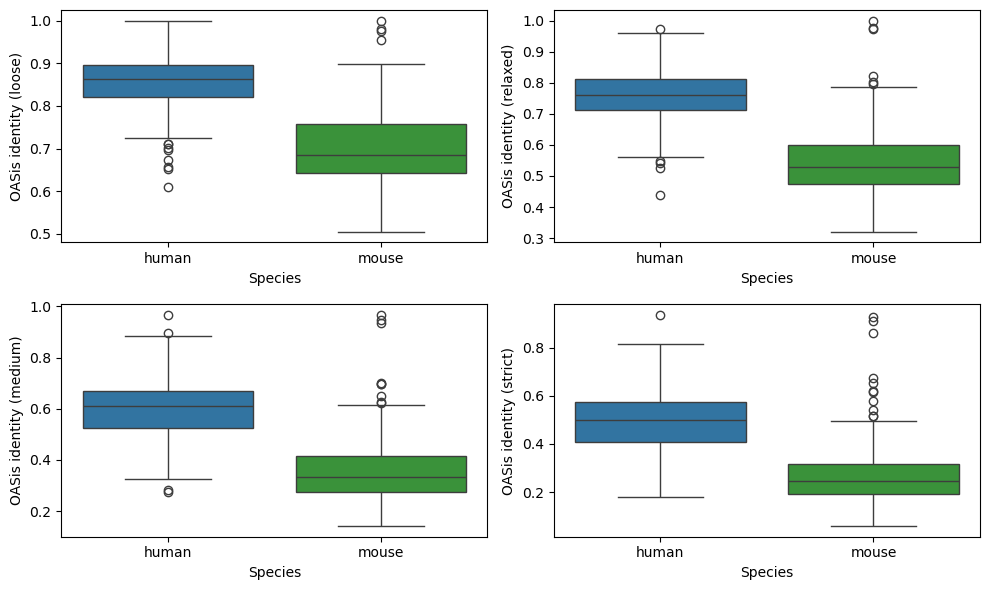

In [16]:
# Draw the data.
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

sns.boxplot(y=oasis_loose, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[0, 0])
sns.boxplot(y=oasis_relaxed, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[0, 1])
sns.boxplot(y=oasis_medium, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[1, 0])
sns.boxplot(y=oasis_strict, x=mabs_data['Species'], order=SPECIES, palette=SPECIES_COLORS, ax=axes[1, 1])
fig.tight_layout()

# sns.boxplot(x=oasis_relaxed, y=mabs_data['Species'])

In [17]:
# Need to get the original humanized 

humanized_fpath = '/data/home/waitma/antibody_proj/antidiff/data/lab_data/humanization_pair_data.xlsx'
humanized_df = pd.read_excel(humanized_fpath)
humanized_df

,Origin/Engineering,name,HC sequence source,HC sequence,LC sequence source,LC sequence,Source,Target sequence,Target sequence source,note
0,mouse,3A3,WO2011112566_20,EVKLEESGGGLVQPGGSMKLSCVASGFTFSNFWMDWVRQSPEKGLE...,WO2011112566_22,DIVMTQSHKFMSTSVGDRVSITCKASQDVSTDVAWYQQKPGQSPKL...,WO2011112566,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
1,humanized,h3A3-5,WO2011112566_27,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_33,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKAPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
2,NaN,h3A3-6,WO2011112566_28,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_33,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKAPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
3,NaN,h3A3-8,WO2011112566_27,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_34,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKSPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
4,NaN,h3A3-9,WO2011112566_28,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_34,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKSPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
...,...,...,...,...,...,...,...,...,...,...
997,humanized,hu16B5,US20170233487A1_7,QVQLVQSGAEVKKPGATVKISCKVSGFNIKDIYMHWVQQAPGKGLE...,US20170233487A1_8,DIVMTQSPDSLAVSLGERATINCKSSQSLLNSRTRKNYLAWYQQKP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN
998,mouse,21B12,US20170233487A1_37,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMHWVKQAPGKGLK...,US20170233487A1_33,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQRP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN
999,humanized,hu21B12,US20170233487A1_17,QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGMHWVRQAPGQGLE...,US20170233487A1_18,DIVMTQSPDSLAVSLGERATINCKSSQSLLYSSNQKNYLAWYQQKP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN
1000,mouse,mu19F6,US20200024362A1_90,EVQLVESGGGLVQPGRSLRLSCTASGFTFSKYVMAWVRQAPTKGLE...,US20200024362A1_89,QFTLTQPKSVSGSLRSTITIPCERSSGDIGDSYVSWYQQHLGRPPI...,US20200024362A1,MIFLYQVVHFILFTSVSGECVTQLLKDTCFEGGDITTVFTPSAKYC...,Uniprot:P03951,NaN


In [18]:
filter_humanized_df = humanized_df[humanized_df['Origin/Engineering'] != 'mouse']

In [19]:
# Need to construct fasta file for compare.

filter_humanized_df = filter_humanized_df.drop_duplicates()
filter_index = filter_humanized_df.index
H_filter_chain_list = [Chain(filter_humanized_df.loc[i]['HC sequence'], scheme='imgt') for i in filter_index]
L_filter_chain_list = [Chain(filter_humanized_df.loc[i]['LC sequence'], scheme='imgt') for i in filter_index]


In [20]:
for i, (h_chain, l_chain) in enumerate(zip(H_filter_chain_list, L_filter_chain_list)):
    new_name = 'humanized' + f'{i}'
    h_chain.name = new_name
    l_chain.name = new_name

save_fasta_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/benchmark_human.fa'
save_pairs(H_filter_chain_list, L_filter_chain_list, save_fasta_fpath)

In [21]:
bench_oasis_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/benchmark_human_oasis.xlsx'
bench_curves = pd.read_excel(bench_oasis_fpath, sheet_name='OASis Curves', index_col=0)
bench_curves.head()

,0%,1%,2%,3%,4%,5%,6%,7%,8%,9%,...,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%
Antibody,,,,,,,,,,,,,,,,,,,,,
humanized0,1.0,0.859903,0.835749,0.835749,0.835749,0.830918,0.830918,0.830918,0.830918,0.826087,...,0.705314,0.705314,0.705314,0.705314,0.705314,0.695652,0.695652,0.695652,0.695652,0.690821
humanized1,1.0,0.850242,0.826087,0.826087,0.826087,0.821256,0.821256,0.821256,0.816425,0.811594,...,0.652174,0.652174,0.652174,0.652174,0.652174,0.647343,0.647343,0.647343,0.647343,0.642512
humanized10,1.0,0.857143,0.829493,0.820276,0.815668,0.797235,0.792627,0.792627,0.792627,0.778802,...,0.608295,0.608295,0.608295,0.599078,0.599078,0.599078,0.599078,0.599078,0.599078,0.594470
humanized100,1.0,0.849315,0.840183,0.840183,0.840183,0.831050,0.812785,0.808219,0.808219,0.808219,...,0.684932,0.680365,0.680365,0.680365,0.675799,0.671233,0.671233,0.671233,0.662100,0.648402
humanized101,1.0,0.811927,0.793578,0.784404,0.779817,0.779817,0.775229,0.766055,0.766055,0.747706,...,0.646789,0.646789,0.646789,0.646789,0.646789,0.646789,0.646789,0.646789,0.646789,0.646789


In [22]:
new_curves = pd.concat([oasis_curves, bench_curves])

In [23]:
# Make sure the threshold of the Biophi
new_oasis_loose = new_curves['1%'].rename('OASis identity (loose)')
new_oasis_relaxed = new_curves['10%'].rename('OASis identity (relaxed)')
new_oasis_medium = new_curves['50%'].rename('OASis identity (medium)')
new_oasis_strict = new_curves['90%'].rename('OASis identity (strict)')

In [24]:
new_curves.index

Index(['humanization1', 'humanization101', 'humanization103',
       'humanization105', 'humanization107', 'humanization109',
       'humanization11', 'humanization111', 'humanization113',
       'humanization115',
       ...
       'humanized90', 'humanized91', 'humanized92', 'humanized93',
       'humanized94', 'humanized95', 'humanized96', 'humanized97',
       'humanized98', 'humanized99'],
      dtype='object', name='Antibody', length=1277)

In [25]:
# Need a mabs to mab the score into different species.
species_list = []
for seq_n in new_curves.index:
    if seq_n[:8] == 'humaniza':
        species_list.append('sample_human')
    elif seq_n[:8] == 'humanize':
        species_list.append('humanized')
    else:
        species_list.append('mouse')
new_antibody_list = new_curves.index

new_data_dict = {

    'Species': species_list
}
new_mabs = pd.DataFrame(new_data_dict, index=new_antibody_list)

In [26]:
# Define some unit.
NEWSPECIES = ['humanized', 'sample_human', 'mouse']
NEWSPECIES_COLORS = ['tab:cyan', 'tab:orange', 'tab:green'] # 'tab:orange', '#dd0033']

/tmp/ipykernel_3531361/1502839463.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=new_oasis_loose, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[0, 0])
/tmp/ipykernel_3531361/1502839463.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=new_oasis_relaxed, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[0, 1])
/tmp/ipykernel_3531361/1502839463.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=new_oasis_medium, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COL

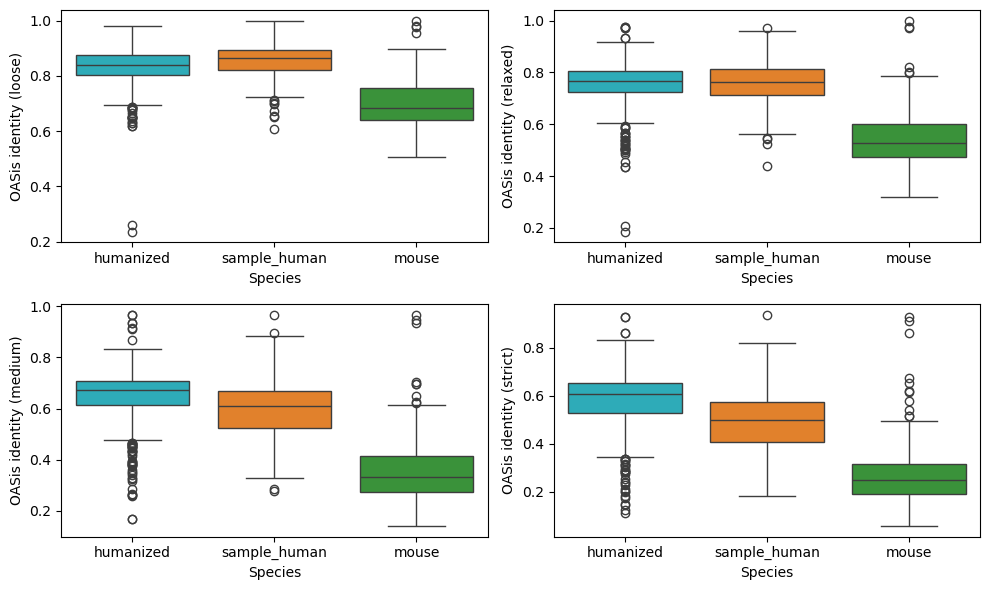

In [27]:
# Draw the data.
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

sns.boxplot(y=new_oasis_loose, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[0, 0])
sns.boxplot(y=new_oasis_relaxed, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[0, 1])
sns.boxplot(y=new_oasis_medium, x=new_mabs['Species'], order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[1, 0])
sns.boxplot(y=new_oasis_strict, x=new_mabs['Species'],order=NEWSPECIES, palette=NEWSPECIES_COLORS, ax=axes[1, 1])
fig.tight_layout()

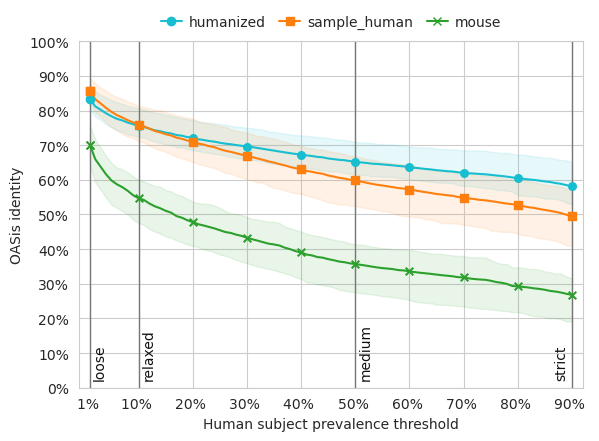

In [28]:
# Curvies draw.
plot_oasis_curves(new_curves, groupby=new_mabs['Species'], errorbars=False, colors=dict(zip(NEWSPECIES, NEWSPECIES_COLORS)))

In [29]:
# Gene Cluster
sample_overview = pd.read_excel(sample_oasis_fpath, sheet_name='Overview', index_col=0)
bench_overview = pd.read_excel(bench_oasis_fpath, sheet_name='Overview', index_col=0)

In [32]:
sample_overview.head()

,Threshold,OASis Percentile,OASis Identity,Germline Content,Heavy V Germline,Heavy J Germline,Heavy OASis Percentile,Heavy OASis Identity,Heavy Non-human peptides,Heavy Germline Content,Light V Germline,Light J Germline,Light OASis Percentile,Light OASis Identity,Light Non-human peptides,Light Germline Content
Antibody,,,,,,,,,,,,,,,,
humanization1,relaxed,0.569699,0.820388,0.801802,IGHV3-72*01,IGHJ4*01,0.338852,0.712963,"(31,)",0.775862,IGKV1-39*01,IGKJ3*01,0.726041,0.938776,6,0.830189
humanization101,relaxed,0.352556,0.740741,0.767241,IGHV1-18*01,IGHJ4*01,0.192286,0.660714,"(38,)",0.741667,IGKV4-1*01,IGKJ2*01,0.520538,0.826923,18,0.794643
humanization103,relaxed,0.525850,0.799065,0.852174,IGHV1-2*02,IGHJ4*01,0.507182,0.781818,"(24,)",0.822034,IGKV4-1*01,IGKJ3*01,0.489462,0.817308,19,0.883929
humanization105,relaxed,0.378951,0.751220,0.809955,IGHV1-18*01,IGHJ4*01,0.162556,0.638889,"(39,)",0.750000,IGKV3-11*01,IGKJ5*01,0.633062,0.876289,12,0.876190
humanization107,relaxed,0.681000,0.875000,0.866379,IGHV3-21*01,IGHJ6*01,0.668571,0.839286,"(18,)",0.816667,IGKV2-30*02,IGKJ2*01,0.692538,0.913462,9,0.919643


In [33]:
bench_overview.head()

,Threshold,OASis Percentile,OASis Identity,Germline Content,Heavy V Germline,Heavy J Germline,Heavy OASis Percentile,Heavy OASis Identity,Heavy Non-human peptides,Heavy Germline Content,Light V Germline,Light J Germline,Light OASis Percentile,Light OASis Identity,Light Non-human peptides,Light Germline Content
Antibody,,,,,,,,,,,,,,,,
humanized0,relaxed,0.553870,0.811594,0.838565,IGHV3-73*01,IGHJ4*01,0.519185,0.787037,"(23,)",0.836207,IGKV1-39*01,IGKJ2*01,0.555313,0.838384,16,0.841121
humanized1,relaxed,0.521333,0.797101,0.816143,IGHV3-73*01,IGHJ4*01,0.453333,0.759259,"(26,)",0.793103,IGKV1-39*01,IGKJ2*01,0.555313,0.838384,16,0.841121
humanized10,relaxed,0.468581,0.774194,0.824034,IGHV1-46*01,IGHJ6*01,0.317250,0.705357,"(33,)",0.783333,IGKV4-1*01,IGKJ4*01,0.578286,0.847619,16,0.867257
humanized100,relaxed,0.546904,0.808219,0.846809,IGHV3-73*01,IGHJ4*01,0.732174,0.860870,"(16,)",0.837398,IGKV2-28*01,IGKJ2*01,0.298000,0.750000,26,0.857143
humanized101,relaxed,0.367183,0.747706,0.846154,IGHV3-11*05,IGHJ4*01,0.448947,0.754386,"(28,)",0.836066,IGKV2-28*01,IGKJ1*01,0.264346,0.740385,27,0.857143


In [41]:
sample_genefamily = sample_overview[['Heavy V Germline', 'Heavy J Germline', 'Light V Germline', 'Light J Germline']]

In [43]:
# Get the Non-mouse chain.
index_filter = lambda x: False if x[:5] == 'mouse' else True
filter_list = [index_filter(idx) for idx in sample_overview.index]

In [44]:
model_sample_gene = sample_genefamily.loc[filter_list, :]

In [48]:
def find_function(v):
    print(v)

In [62]:
# Get H gene of sample
H_gene_list = []
for idx, line in model_sample_gene.iterrows():
    H_v = line['Heavy V Germline']
    H_j = line['Heavy J Germline']
    split = (H_v.split('*')[0], H_j.split('*')[0])
    H_gene_list.append(split)
H_gene_df = pd.Series(H_gene_list, name='h_gene_pair', index=model_sample_gene.index)

In [65]:
H_gene_df.value_counts(normalize=True).head(20).apply('{:.0%}'.format)

h_gene_pair
(IGHV1-46, IGHJ4)      11%
(IGHV1-2, IGHJ4)        8%
(IGHV3-23, IGHJ4)       6%
(IGHV5-51, IGHJ4)       5%
(IGHV1-3, IGHJ4)        4%
(IGHV7-4-1, IGHJ4)      4%
(IGHV1-18, IGHJ4)       3%
(IGHV1-2, IGHJ2)        3%
(IGHV3-48, IGHJ4)       3%
(IGHV2-5, IGHJ4)        3%
(IGHV5-10-1, IGHJ4)     2%
(IGHV3-73, IGHJ4)       2%
(IGHV4-38-2, IGHJ4)     2%
(IGHV4-59, IGHJ4)       2%
(IGHV1-46, IGHJ2)       2%
(IGHV3-23, IGHJ6)       2%
(IGHV3-72, IGHJ4)       2%
(IGHV5-10-1, IGHJ2)     1%
(IGHV2-5, IGHJ6)        1%
(IGHV1-2, IGHJ6)        1%
Name: proportion, dtype: object

In [66]:
# Get L gene of sample
L_gene_list = []
for idx, line in model_sample_gene.iterrows():
    L_v = line['Light V Germline']
    L_j = line['Light J Germline']
    split = (L_v.split('*')[0], L_j.split('*')[0])
    L_gene_list.append(split)
L_gene_df = pd.Series(L_gene_list, name='l_gene_pair', index=model_sample_gene.index)

In [67]:
L_gene_df.value_counts(normalize=True).head(20).apply('{:.0%}'.format)

l_gene_pair
(IGKV1-39, IGKJ1)    7%
(IGKV4-1, IGKJ4)     6%
(IGKV4-1, IGKJ1)     5%
(IGKV1-39, IGKJ2)    4%
(IGKV4-1, IGKJ2)     4%
(IGKV2-30, IGKJ1)    3%
(IGKV1-39, IGKJ4)    3%
(IGKV1-33, IGKJ2)    3%
(IGKV4-1, IGKJ3)     3%
(IGKV2-30, IGKJ2)    2%
(IGKV2-29, IGKJ2)    2%
(IGKV1-16, IGKJ2)    2%
(IGKV1-33, IGKJ1)    2%
(IGKV1-39, IGKJ3)    2%
(IGKV3-11, IGKJ4)    2%
(IGKV2-24, IGKJ2)    2%
(IGKV3-20, IGKJ4)    2%
(IGKV2-30, IGKJ4)    2%
(IGKV1-33, IGKJ4)    2%
(IGKV3-15, IGKJ3)    2%
Name: proportion, dtype: object

In [68]:
bench_genefamily = bench_overview[['Heavy V Germline', 'Heavy J Germline', 'Light V Germline', 'Light J Germline']]

In [69]:
bench_genefamily

,Heavy V Germline,Heavy J Germline,Light V Germline,Light J Germline
Antibody,,,,
humanized0,IGHV3-73*01,IGHJ4*01,IGKV1-39*01,IGKJ2*01
humanized1,IGHV3-73*01,IGHJ4*01,IGKV1-39*01,IGKJ2*01
humanized10,IGHV1-46*01,IGHJ6*01,IGKV4-1*01,IGKJ4*01
humanized100,IGHV3-73*01,IGHJ4*01,IGKV2-28*01,IGKJ2*01
humanized101,IGHV3-11*05,IGHJ4*01,IGKV2-28*01,IGKJ1*01
...,...,...,...,...
humanized95,IGHV3-72*01,IGHJ4*01,IGKV1-39*01,IGKJ2*01
humanized96,IGHV3-72*01,IGHJ4*01,IGKV1-39*01,IGKJ2*01
humanized97,IGHV1-46*01,IGHJ4*01,IGKV1-9*01,IGKJ2*01


In [70]:
# Get H gene of bench
ref_H_gene_list = []
for idx, line in bench_genefamily.iterrows():
    H_v = line['Heavy V Germline']
    H_j = line['Heavy J Germline']
    split = (H_v.split('*')[0], H_j.split('*')[0])
    ref_H_gene_list.append(split)
ref_H_gene_df = pd.Series(ref_H_gene_list, name='h_gene_pair', index=bench_genefamily.index)

In [78]:
ref_H_gene_df.value_counts(normalize=True).head(20).apply('{:.0%}'.format)

h_gene_pair
(IGHV1-46, IGHJ4)      11%
(IGHV1-3, IGHJ4)        8%
(IGHV3-23, IGHJ4)       6%
(IGHV1-2, IGHJ4)        5%
(IGHV1-69, IGHJ4)       3%
(IGHV1-46, IGHJ6)       3%
(IGHV7-4-1, IGHJ6)      3%
(IGHV3-48, IGHJ4)       3%
(IGHV7-4-1, IGHJ4)      2%
(IGHV3-73, IGHJ4)       2%
(IGHV3-72, IGHJ4)       2%
(IGHV4-4, IGHJ4)        2%
(IGHV2-5, IGHJ4)        2%
(IGHV3-66, IGHJ4)       2%
(IGHV4-30-4, IGHJ4)     2%
(IGHV1-2, IGHJ6)        2%
(IGHV1-18, IGHJ4)       1%
(IGHV1-46, IGHJ2)       1%
(IGHV3-49, IGHJ4)       1%
(IGHV1-2, IGHJ2)        1%
Name: proportion, dtype: object

In [77]:
ref_h_counts.index

Index([  ('IGHV1-46', 'IGHJ4'),    ('IGHV1-3', 'IGHJ4'),
         ('IGHV3-23', 'IGHJ4'),    ('IGHV1-2', 'IGHJ4'),
         ('IGHV1-69', 'IGHJ4'),   ('IGHV1-46', 'IGHJ6'),
        ('IGHV7-4-1', 'IGHJ6'),   ('IGHV3-48', 'IGHJ4'),
        ('IGHV7-4-1', 'IGHJ4'),   ('IGHV3-73', 'IGHJ4'),
         ('IGHV3-72', 'IGHJ4'),    ('IGHV4-4', 'IGHJ4'),
          ('IGHV2-5', 'IGHJ4'),   ('IGHV3-66', 'IGHJ4'),
       ('IGHV4-30-4', 'IGHJ4'),    ('IGHV1-2', 'IGHJ6'),
         ('IGHV1-18', 'IGHJ4'),   ('IGHV1-46', 'IGHJ2'),
         ('IGHV3-49', 'IGHJ4'),    ('IGHV1-2', 'IGHJ2')],
      dtype='object', name='h_gene_pair')

In [73]:
# Get H gene of bench
ref_L_gene_list = []
for idx, line in bench_genefamily.iterrows():
    L_v = line['Light V Germline']
    L_j = line['Light J Germline']
    split = (L_v.split('*')[0], L_j.split('*')[0])
    ref_L_gene_list.append(split)
ref_L_gene_df = pd.Series(ref_L_gene_list, name='l_gene_pair', index=bench_genefamily.index)

In [85]:
ref_L_gene_df.value_counts(normalize=True).head(20).apply('{:.0%}'.format)

l_gene_pair
(IGKV4-1, IGKJ2)      0.080620
(IGKV1-39, IGKJ2)     0.071318
(IGKV1-39, IGKJ1)     0.071318
(IGKV4-1, IGKJ4)      0.065116
(IGKV4-1, IGKJ1)      0.044961
(IGKV2-30, IGKJ2)     0.035659
(IGKV1-39, IGKJ4)     0.032558
(IGKV3-11, IGKJ1)     0.029457
(IGKV2-28, IGKJ2)     0.026357
(IGKV2-30, IGKJ1)     0.024806
(IGKV3-11, IGKJ2)     0.023256
(IGKV1-33, IGKJ4)     0.023256
(IGKV3-11, IGKJ4)     0.021705
(IGKV1-16, IGKJ2)     0.021705
(IGKV1-33, IGKJ1)     0.020155
(IGKV1-33, IGKJ2)     0.020155
(IGKV2-30, IGKJ4)     0.018605
(IGKV1-NL1, IGKJ2)    0.015504
(IGKV1-9, IGKJ2)      0.015504
(IGKV2-28, IGKJ1)     0.015504
Name: proportion, dtype: float64

<Axes: xlabel='h_gene_pair'>

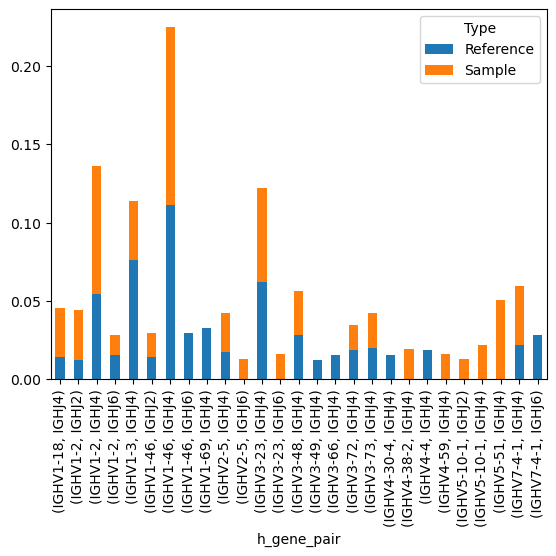

In [89]:
# Draw H gene.
sample_h_gene_df = H_gene_df.value_counts(normalize=True).head(20).apply(pd.to_numeric).to_frame()
ref_h_gene_df = ref_H_gene_df.value_counts(normalize=True).head(20).apply(pd.to_numeric).to_frame()

sample_h_gene_df['Type'] = 'Sample'
ref_h_gene_df['Type'] = 'Reference'

df = pd.concat([sample_h_gene_df, ref_h_gene_df], axis=0)
df = df.pivot_table(index='h_gene_pair', columns='Type', values='proportion', fill_value=0)

df.plot(kind='bar', stacked=True)

<Axes: xlabel='l_gene_pair'>

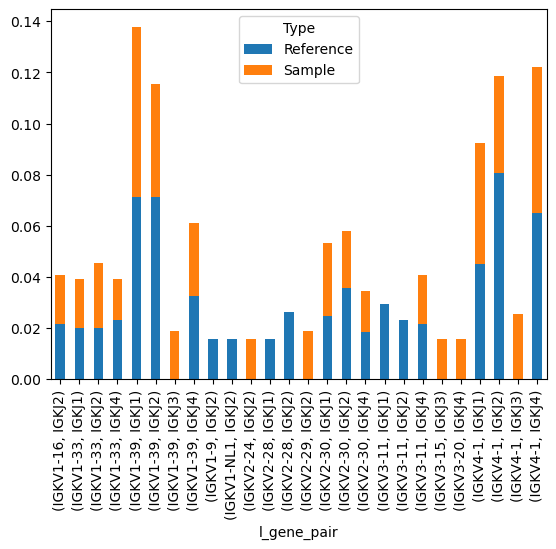

In [90]:
# Draw L gene.
sample_l_gene_df = L_gene_df.value_counts(normalize=True).head(20).apply(pd.to_numeric).to_frame()
ref_l_gene_df = ref_L_gene_df.value_counts(normalize=True).head(20).apply(pd.to_numeric).to_frame()

sample_l_gene_df['Type'] = 'Sample'
ref_l_gene_df['Type'] = 'Reference'

df = pd.concat([sample_l_gene_df, ref_l_gene_df], axis=0)
df = df.pivot_table(index='l_gene_pair', columns='Type', values='proportion', fill_value=0)

df.plot(kind='bar', stacked=True)